# AUTHOR
***Written by Ho Sy The***

Hanoi University of Science and Technology

IT1 04 - K65.

*Github: https://github.com/hsthe29*

- **date: 2022-05-18**

# SUMMARY
## Gradient Descent approach
- Lagrangian dual function after applying kernel function $k(\mathbf{x}_m, \mathbf{x}_n)$: 
$\begin{eqnarray}
    g(λ)&=& \min_{\lambda}~~\frac{1}{2} \sum_{n=1}^N\sum_{m=1}^N \lambda_n \lambda_m y_n y_m k(\mathbf{x}_n,\mathbf{x}_m) ~~ - \sum_{n=1}^N \lambda_n &&\ 
    \text{subject to:}~ && \sum_{n=1}^N \lambda_ny_n = 0 &&\quad\quad\quad\quad\ 
    && 0 \leq \lambda_n \leq C, ~\forall n= 1, 2, \dots, N &&
\end{eqnarray}$ and
$~~\sum_{m \in \mathcal{S}} \lambda_m y_m k(\mathbf{x}_m, \mathbf{x}) + \frac{1}{N_{\mathcal{M}}} \sum_{n \in \mathcal{M}} \left(y_n - \sum_{m \in \mathcal{S}} \lambda_m y_m k(\mathbf{x}_m, \mathbf{x}_n)\right)~~~~~~~~~$


## Build loss function
- Firstly, we rewrite $g(λ)$ as follows:

$~~~~~g(\lambda)  = \frac{1}{2} λ^TQλ - \sum_{j=1}^n\lambda_i$
- As we known $\frac{\delta (\mathbf{x}^TQ\mathbf{x})}{\delta \mathbf{x}} = (Q + Q^T)\mathbf{x}$
- Therefore:

$~~~~~\frac{\delta g(\lambda_i)}{\delta \lambda} = \frac{1}{2}(Q + Q^T)λ - 1$
 - Cause $Q$ is symmetric matrix, that means $Q = Q^T$
 $⇒\frac{\delta g(\lambda_i)}{\delta \lambda} = Qλ - 1$

- Update rule also for SGD and Mini-batch Gradient Descent:

$\lambda = \lambda-\eta \Delta g(\lambda) \\
= \lambda-\eta\frac{\delta g(\lambda )}{\delta \lambda} \\
 = \lambda-\eta \bigg ( Qλ - 1 \bigg )$



In [7]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
# check gradient formula, we'll accept if gradient different less than 1e-6

Q = np.random.rand(1, 20)
Q = Q.T @ Q

def cost(w): # w: [n, 1]
    return .5 * (w.T @ Q @ w) - np.sum(w) 

def grad(w): # w: [n, 1]
    return Q @ w - 1

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

w0 = np.random.randn(20, 1) 
g1 = grad(w0)
print('g1 = ', g1.T)
g2 = num_grad(w0)
print('g2 = ', g2.T)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

g1 =  [[-1.77899871 -1.52504303 -3.43280018 -3.39010525 -2.17010358 -4.81531551
  -3.53241457 -4.06129775 -1.56822353 -4.32282241 -1.21398743 -3.21891183
  -3.93638219 -2.77513117 -4.32184162 -3.40393998 -4.6268345  -1.85515299
  -2.77733721 -1.65066355]]
g2 =  [[-1.77899871 -1.52504303 -3.43280018 -3.39010525 -2.17010358 -4.81531551
  -3.53241457 -4.06129775 -1.56822354 -4.32282241 -1.21398743 -3.21891183
  -3.93638219 -2.77513117 -4.32184162 -3.40393997 -4.6268345  -1.85515299
  -2.77733721 -1.65066355]]
Gradient different: 0.000000


In [3]:
class KernelSVM:
  def __init__(self, kernel='rbf', learning_rate=1e-3, C=1e5, degree=3, gamma=0, coeff=0):
    self.__kernels = {'linear': lambda x, y: self.__linear_kernel_(x, y),
             'poly': lambda x, y: self.__polynomial_kernel_(x, y),
             'sigmoid': lambda x, y: self.__sigmoid_kernel_(x, y),
             'rbf': lambda x, y: self.__rbf_kernel_(x, y)}
    if kernel not in self.__kernels.keys():
      raise ValueError('kernel is not accepted!')
    self.__kernel= kernel
    self.lr = learning_rate
    self.__C = C
    self.__degree = degree
    self.__gamma = gamma
    self.__coeff = coeff
  
  def __linear_kernel_(self, X1, X2):
    return X1.T @ X2 # [N, N]

  def __polynomial_kernel_(self, X1, X2):
    x = X1.T @ X2 # [N, N]
    return (self.__gamma * x + self.__coeff) ** self.__degree

  def __sigmoid_kernel_(self, X1, X2):
    x = X1.T @ X2 # [N, N]
    return np.tanh(self.__gamma * x + self.__coeff)

  def __rbf_kernel_(self, X1, X2):
    d, n = X1.shape
    _, n2 = X2.shape
    X1_ = X1.reshape(d, n, 1)
    X2_ = X2.reshape(d, n2, 1)
    one1 = np.ones((d, 1, n))
    one2 = np.ones((d, 1, n2))
    ans = (X1_ @ one2 - (X2_ @ one1).transpose(0, 2, 1)) ** 2 
    return np.exp(-self.__gamma * np.sum(ans, axis=0))
  
  # using mini-batch GD
  def fit(self, X, y, batch_size=0, epochs=100001, show_result=False):
    # if batch_size is 0, this case is SGD
    if batch_size == 0:
      batch_size = X.shape[1]
    else:
      if X.shape[1] % batch_size != 0:
        raise ValueError('number of data points must be divisible by batch_size!')
    self.epochs = epochs
    self.classes = np.unique(y)
    if len(self.classes) != 2:
      raise ValueError('Number of classed must be 2!')

    self.X = X
    self.y = y
    self.y[self.y == self.classes[0]] = -1
    self.y[self.y == self.classes[1]] = 1
    self.lambda_ = np.random.rand(X.shape[1], 1) # [n, 1]
    self.loss_ = []

    # build Q
    Q = np.outer(y, y) * self.__kernels[self.__kernel](X, X) # [n, n] x [n, n] = [n, n]
    iter_per_epoch = X.shape[1] // batch_size
    for _ in range(self.epochs):
      mix_id = np.random.permutation(X.shape[1])
      for i in range(iter_per_epoch):
        id = mix_id[range(i * batch_size, (i + 1) * batch_size)]
        Q1 = Q[id][:, id]
        # .5 * (Q + Q.T) @ w - 1
        gradient = Q1 @ self.lambda_[id] - 1 # [n, 1], 

        self.lambda_[id] = self.lambda_[id] - self.lr * gradient

        self.lambda_[self.lambda_ > self.__C] = self.__C
        self.lambda_[self.lambda_ < 0] = 0
      loss = .5 * (self.lambda_.T @ Q @ self.lambda_) - np.sum(self.lambda_)
      self.loss_.append(loss[0, 0])
    
    if show_result:
      plt.figure(figsize=(20, 8))
      plt.plot(self.loss_, 'b', linewidth=2)
      plt.plot(self.loss_, 'ro', markersize=5)
      plt.title('loss - epochs')
      plt.xlabel('epochs')
      plt.ylabel('loss value')
      plt.show()
      print('λ.T: ')
      print(self.lambda_.T)

    self.M_ = np.where((self.lambda_ > 0) & (self.lambda_ < self.__C))[0]
    self.S_ = np.where(self.lambda_ > 0)[0]
    self.b_ = self.y[:, self.M_] - (self.lambda_[self.S_].T * self.y[:, self.S_])\
          .dot(self.__kernels[self.__kernel](self.X[:, self.S_], self.X[:, self.M_]))\
          if len(self.M_) > 0 else 0.0

  def _decision_function(self, X):
    w_t = (self.lambda_[self.S_].T * self.y[:, self.S_])\
          .dot(self.__kernels[self.__kernel](self.X[:, self.S_], X))
    return w_t + np.mean(self.b_)

  def predict(self, X, keepclass=False):
    ans = np.sign(self._decision_function(X))
    ans[ans == 0] = 1
    if keepclass:
      ans[ans == -1] = self.classes[0]
      ans[ans == 1] = self.classes[1]
    return ans
  def visualize(self, x_axis, y_axis, n_=500, level_sets=200, dpi=100, style=1):
    plt.figure(dpi=dpi)

    x_ = np.linspace(x_axis[0], x_axis[1], n_)
    y_ = np.linspace(y_axis[0], y_axis[1], n_)
    l = len(x_)
    x_, y_ = np.meshgrid(x_, y_)

    xx = x_.reshape(-1)
    yy = y_.reshape(-1)
    x = np.vstack((xx, yy))
    z = self._decision_function(x)
    z = z.reshape(l, l)

    if style == 1:
      plt.contourf(x_, y_, np.sign(z), level_sets, cmap='jet', alpha = .3)
      X_1 = self.X[:, self.y[0] == -1]
      X_2 = self.X[:, self.y[0] == 1]
      plt.plot(X_1[0], X_1[1], 'ro', markersize=8, markeredgecolor='k')
      plt.plot(X_2[0], X_2[1], 'bs', markersize=8, markeredgecolor='k')
    else:
      plt.contour(x_, y_, z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])
      yc = np.copy(self.y)
      yc[yc == -1] = 0
      plt.scatter(self.X[0], self.X[1], c=yc[0], s=50, cmap=plt.cm.Paired, alpha=.8)
    plt.axis('tight')

    plt.contour(x_, y_, z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.show()



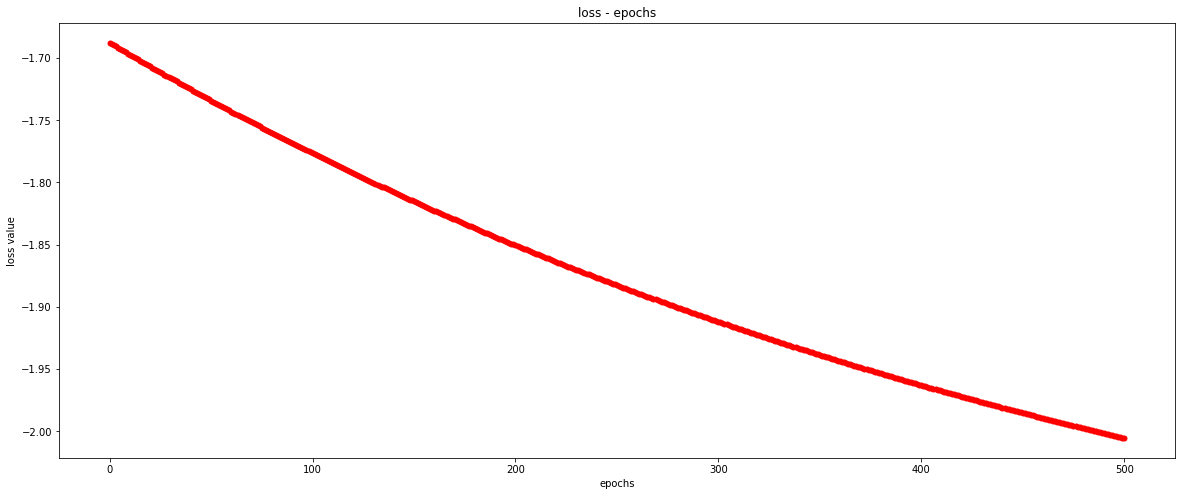

λ.T: 
[[0.71396229 0.63991004 1.01089584 0.83755455]]


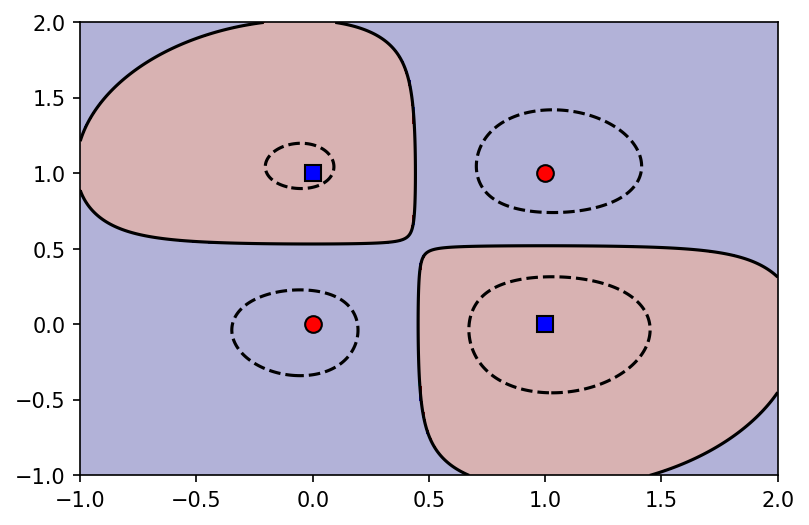

In [4]:
X = np.array([[0, 0],
             [0, 1],
             [1, 0],
             [1, 1]], dtype='float64').T
y = np.array([[-1, 1, 1, -1]], dtype='float64')

ksvm = KernelSVM(kernel='rbf',C = 1000, gamma=3, coeff=0)

ksvm.fit(X, y, epochs=501, show_result=True)
ksvm.visualize([-1, 2], [-1, 2], dpi=150)

# Moon dataset

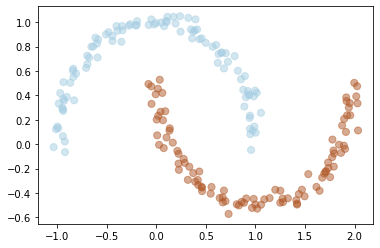

In [5]:
def make_data(n_samples, noise=0.05):
  noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=6)
  return noisy_moons[0], noisy_moons[1]


n_data = 200
X2, y2 = make_data(n_data)
X2 = X2.T
y2 = y2.reshape(1, n_data)

y2 = y2.astype(float)

plt.scatter(X2[0], X2[1], c=y2, s=50, cmap=plt.cm.Paired, alpha=.5)
plt.show()


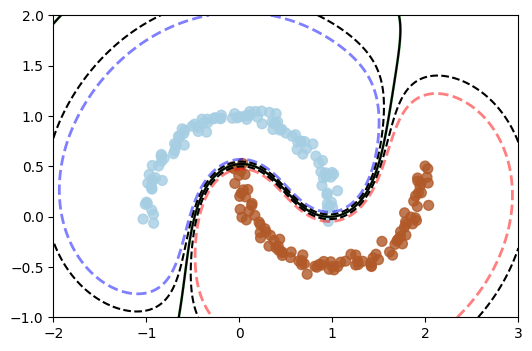

In [6]:
ksvm2 = KernelSVM(kernel='rbf',C=1, learning_rate=1e-2, gamma=2)

ksvm2.fit(X2, y2, epochs=501, batch_size=20, show_result=False)

ksvm2.visualize([-2, 3], [-1, 2], style=2)

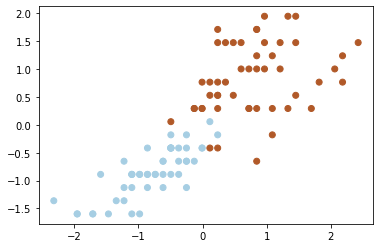

In [8]:
def load_data(cols):
  iris = sns.load_dataset("iris")
  iris = iris.tail(100)

  le = preprocessing.LabelEncoder()
  yt = le.fit_transform(iris["species"])

  Xt = iris.drop(["species"], axis=1)

  if len(cols) > 0:
    Xt = Xt[cols]

  return Xt.values, yt

cols = ["petal_length", "petal_width"]
X3, y3 = load_data(cols)

y3[y3 == 0] = -1
y3 = np.array([y3])
y3 = y3.astype(float)

# scale the data
scaler = StandardScaler()
X3 = scaler.fit_transform(X3)
X3 = X3.T

plt.scatter(X3[0], X3[1],c=y3, cmap=plt.cm.Paired)
plt.show()

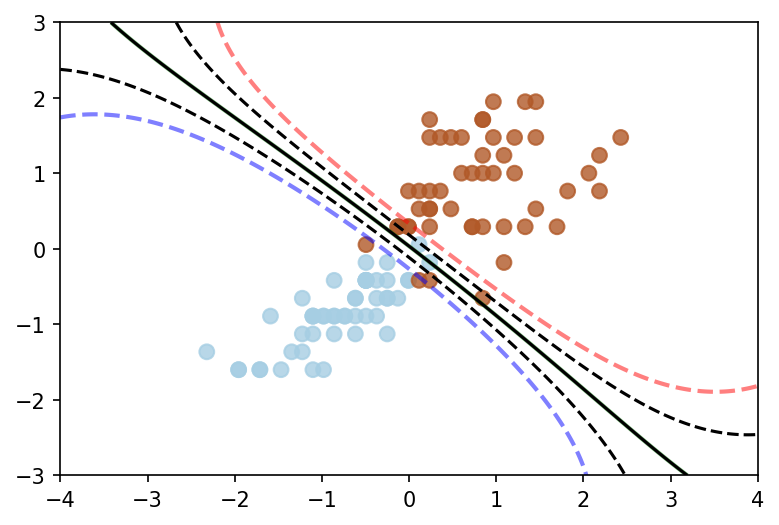

In [19]:
ksvm_1 = KernelSVM(kernel='rbf',C=10, learning_rate=1e-3, gamma=.1)

ksvm_1.fit(X3, y3, epochs=501, batch_size=20, show_result=False)

ksvm_1.visualize([-4, 4], [-3, 3], style=2, dpi=150)

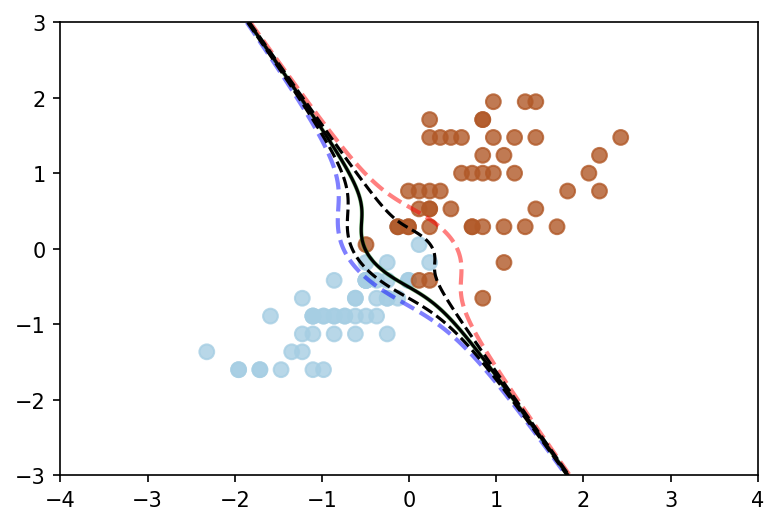

In [26]:
ksvm_2 = KernelSVM(kernel='poly',C=200, learning_rate=1e-3, gamma=1)

ksvm_2.fit(X3, y3, epochs=501, batch_size=20, show_result=False)

ksvm_2.visualize([-4, 4], [-3, 3], style=2, dpi=150)

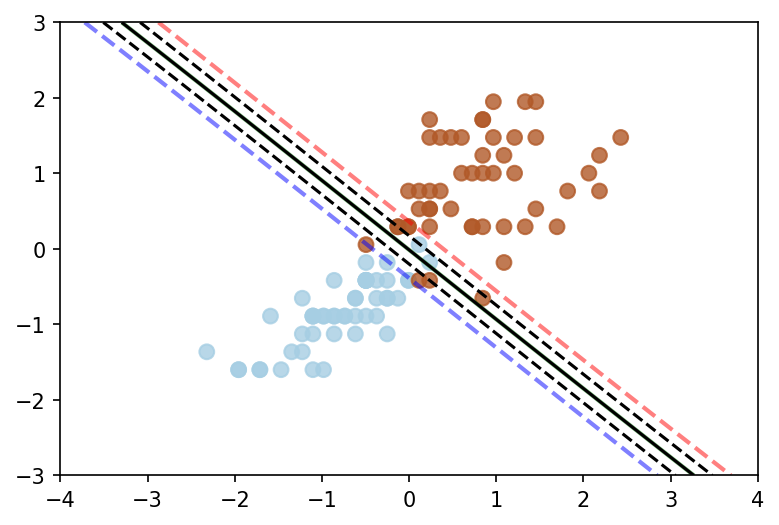

In [27]:
ksvm_3 = KernelSVM(kernel='sigmoid',C=10, learning_rate=1e-3, gamma=.1)

ksvm_3.fit(X3, y3, epochs=501, batch_size=20, show_result=False)

ksvm_3.visualize([-4, 4], [-3, 3], style=2, dpi=150)

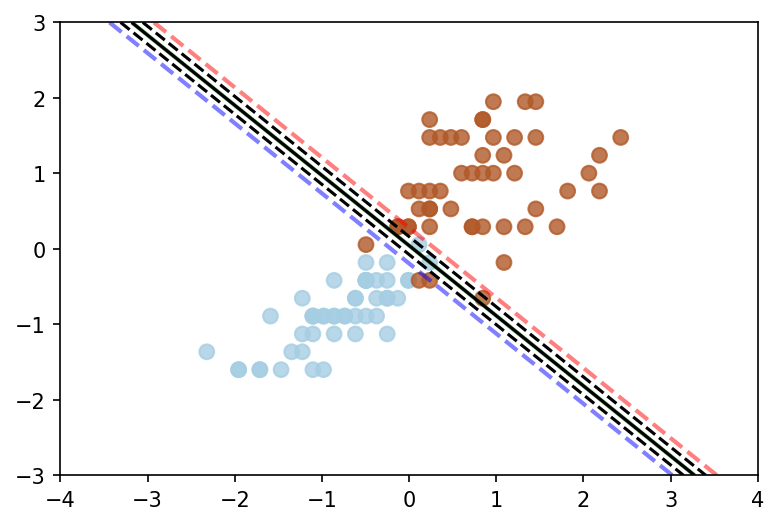

In [29]:
ksvm_4 = KernelSVM(kernel='linear',C=10, learning_rate=1e-3)

ksvm_4.fit(X3, y3, epochs=501, batch_size=20, show_result=False)

ksvm_4.visualize([-4, 4], [-3, 3], style=2, dpi=150)